In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('..')
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
from joblib import delayed, Parallel, parallel_backend
import time
from operator import itemgetter
ig0 = itemgetter(0)
ig1 = itemgetter(1)
ig2 = itemgetter(2)

In [3]:
#Import python packages
from geomle import DataGenerator, geomle, mle

#Import R packages
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.numpy2ri import ri2py, py2ri
from rpy2.robjects.packages import importr
intdimr = importr('intrinsicDimension')
r_base = importr('base')

#Import C++ packages
import hein

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def calculate_time(func): 
    def inner_func(*args, **kwargs): 
        begin = time.time() 
        res = func(*args, **kwargs) 
        end = time.time()
        return res, end - begin
    return inner_func

In [6]:
# k1_sigmoid = lambda x: int(round(20 / (1 + np.exp( -0.05 * x))))
# k2_sigmoid = lambda x: int(round(60 / (1 + np.exp( -0.03 * (x + 5)))))

CPU_COUNT = os.cpu_count()
k1_log = lambda x: int(np.round(3 * np.log(1/3 * x) + 10))
k2_log = lambda x: int(np.round(12 * np.log(1/12 * (x + 10)) + 30))

class DimEst():
    def __init__(self):
        self.names = ['MLE', 'GeoMLE', 'MIND', 'DANCo', 'ESS', 'PCA', 'CD', 'Hein']
    
    def estimateAllMethod(self, data_py):
        data_r = py2ri(data_py.values)
        dim = data_py.shape[1]
        self.funcs = {'MLE':          self.mle(data_py),
                      'GeoMLE':       self.geomle(data_py, dim),
                      'MiND':         self.mind_mlk(data_r, dim),
                      'DANCo':        self.danco(data_r, dim),
                      'ESS':          self.ess(data_r),
                      'PCA':          self.pca(data_r),
                      'CD':           self.cd(data_py),
                      'Hein':         self.hein(data_py)}
        self.times = {key: ig1(val) for key, val in self.funcs.items()}
        self.funcs = {key: ig0(val) for key, val in self.funcs.items()}
        return self.funcs, self.times
    
    @staticmethod
    @calculate_time
    def mle(data):
        return mle(data, k1=6, k2=20, average=True)[0].mean()
    
    @staticmethod
    @calculate_time
    def geomle(data, dim):
        k1 =  k1_log(dim)
        k2 =  k2_log(dim)
        return geomle(data, k1=k1, k2=k2, nb_iter1=1, alpha=5e-3).mean()
    
    @staticmethod
    @calculate_time
    def mind_mlk(data, dim):
        return intdimr.dancoDimEst(data, k=10, D=dim, ver="MIND_MLk").rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def danco(data, dim):
        return intdimr.dancoDimEst(data, k=10, D=dim, ver="DANCo").rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def ess(data):
        return intdimr.essLocalDimEst(data).rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def pca(data):
        return intdimr.pcaLocalDimEst(data, 'FO').rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def hein(data):
        res = hein.heindim(data)
        return res[0]
    
    @staticmethod
    @calculate_time
    def cd(data):
        res = hein.heindim(data)
        return res[1]

In [7]:
DE = DimEst()

In [8]:
DG = DataGenerator()

In [9]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid'])

In [10]:
data = DG.gen_data('Paraboloid', 1000, 21, 6)
DE.estimateAllMethod(data)[0]

{'MLE': 4.672018580719461,
 'GeoMLE': 5.84265173016156,
 'MiND': 5,
 'DANCo': 7,
 'ESS': 1.4588936706687714,
 'PCA': 1,
 'CD': 2.275836229324341,
 'Hein': 2.0}

In [11]:
data = DG.gen_data('Nonlinear_4to6', 1000, 6, 4)
DE.estimateAllMethod(data)[0]

{'MLE': 3.873028239252456,
 'GeoMLE': 4.061924608874724,
 'MiND': 4,
 'DANCo': 5,
 'ESS': 3.0910166927096636,
 'PCA': 5,
 'CD': 3.8351616859436035,
 'Hein': 4.0}

In [12]:
DE.estimateAllMethod(data)[1]

{'MLE': 0.1721022129058838,
 'GeoMLE': 1.743913173675537,
 'MiND': 0.0074462890625,
 'DANCo': 1.1206135749816895,
 'ESS': 0.1392650604248047,
 'PCA': 0.0004208087921142578,
 'CD': 0.019899368286132812,
 'Hein': 0.019797086715698242}

In [13]:
data = DG.gen_data('Sphere', 1000, 6, 4, 'uniform')
DE.estimateAllMethod(data)[0]

{'MLE': 3.9331999127486075,
 'GeoMLE': 3.972448286138356,
 'MiND': 4,
 'DANCo': 4,
 'ESS': 5.020505023294279,
 'PCA': 5,
 'CD': 3.5972938537597656,
 'Hein': 4.0}

In [14]:
data = DG.gen_data('Sphere', 1000, 6, 4, 'nonuniform')
DE.estimateAllMethod(data)[0]

{'MLE': 3.8025403170544227,
 'GeoMLE': 3.864852997101525,
 'MiND': 4,
 'DANCo': 4,
 'ESS': 4.99586479793099,
 'PCA': 5,
 'CD': 4.091396808624268,
 'Hein': 4.0}

## Decribing algorithm

### Explain k1 and k2 dependancy

In [13]:
ds = np.arange(2, 150)
k1_log_arr = np.array(list(map(k1_log, ds)))
k2_log_arr = np.array(list(map(k2_log, ds)))

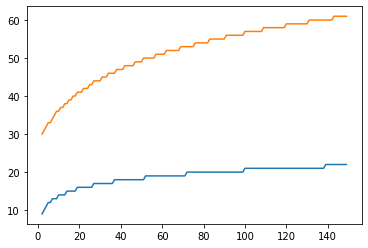

In [14]:
plt.plot(ds, k1_log_arr)
plt.plot(ds, k2_log_arr)

### Explain main idea of algorithms

In [16]:
from sklearn.linear_model import Ridge

In [48]:
df = []
name = 'Sphere'
N = 1000
ds = [6, 7, 8, 9]

for d in ds:
    data = DG.gen_data(name, N, d+1, d)
    res, id_data = geomle(data, k1=7, k2=40, nb_iter1=1, debug=True)
    df.append(id_data[0])

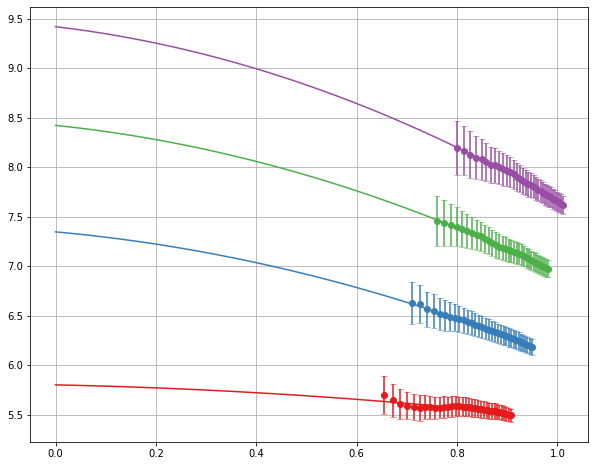

In [63]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))


alpha_poly = (1, 2)
alpha_reg = 1e-2

cm = plt.cm.get_cmap('Set1', 10)
save_data = []


for i in range(len(df)):
    gr_df = df[i].groupby(['k', 'idx']).mean().reset_index().groupby('k')

    x = gr_df['R'].mean().values
    y = gr_df['dim'].mean().values
    w = gr_df['dim'].std().values
    save_data.append([x, y, w])
    X = np.array([x ** i for i in alpha_poly]).T

    xlin = np.linspace(0, x.max(), 100)
    Xlin = np.array([xlin ** i for i in alpha_poly]).T
    lm = Ridge(alpha=alpha_reg)
    lm.fit(X, y, w **-1)
    plt.errorbar(x, y, w * 0.1, fmt='o', color=cm(i), capsize=3, capthick=0.5)
    plt.plot(xlin, lm.predict(Xlin), color=cm(i))

# ax.legend()
ax.grid()
plt.show()


In [64]:
np.save('result/exp_new.npy', save_data)

## Density test

In [65]:
def gen_sphere_data_with_distribution(n, dim, d, distrib):
    if distrib == 'uniform':
        V = np.random.randn(n,d + 1)
    elif distrib == 'nonuniform':
        V = (np.random.rand(n,d + 1) - 0.5) * 3
    data = pd.DataFrame(np.hstack([V/np.sqrt(np.sum(V**2, axis=1))[:,None],
                                          np.zeros((n, dim - d - 1))]))
    assert data.shape == (n, dim)
    return data

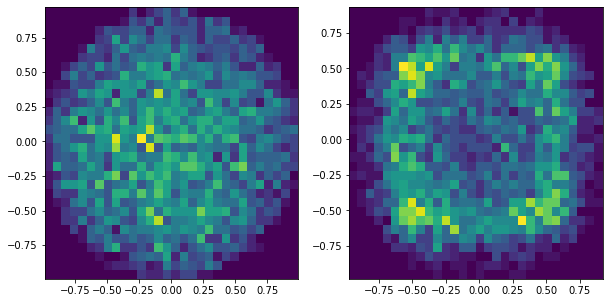

In [66]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
data = gen_sphere_data_with_distribution(5000, 5, 4, 'uniform')
plt.hist2d(data[0], data[1], bins=30)

plt.subplot(122)
data = gen_sphere_data_with_distribution(5000, 5, 4, 'nonuniform')
plt.hist2d(data[0], data[1], bins=30)

plt.show()

In [67]:
res = []
for i in tqdm(range(10)):
    data = gen_sphere_data_with_distribution(1000, 7, 5, 'uniform')
    res.append([mle(data)[0].mean(), geomle(data, nb_iter1=1, k1=10, k2=40).mean()])
                
res = np.mean(res, axis=0)
print('Uniform')
print('MLE:    {:.4f}'.format(res[0]))
print('GeoMLE: {:.4f}'.format(res[1]))


res = []
for i in tqdm(range(10)):
    data = gen_sphere_data_with_distribution(1000, 7, 5, 'nonuniform')
    res.append([mle(data)[0].mean(), geomle(data, nb_iter1=1, k1=10, k2=40).mean()])
                
res = np.mean(res, axis=0)
print('NonUniform')
print('MLE:    {:.4f}'.format(res[0]))
print('GeoMLE: {:.4f}'.format(res[1]))

  0%|          | 0/10 [00:00<?, ?it/s]

Uniform
MLE:    4.8265
GeoMLE: 4.9733


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

NonUniform
MLE:    4.5704
GeoMLE: 4.7797


## Funcs

In [15]:
def run_one_test(args):
    try:
        data = DG.gen_data(args['name'], args['N'], args['D'], args['d'], args['noise'])
        res, t = DE.estimateAllMethod(data)
        res['Dataset'] = args['name']
        res['Num'] = args['N']
        res['Dim'] = args['D']
        res['RealDim'] = args['d']
        t['Dataset'] = args['name']
        t['Num'] = args['N']
        t['Dim'] = args['D']
        t['RealDim'] = args['d']
        return list(res.values()), list(t.values())
    except:
        print('WRONG with {}'.format(args))


In [16]:
def run_test(func, steps, const_args, n_repetition, n_jobs=CPU_COUNT, return_time=False):
    with parallel_backend('multiprocessing'):
        result = Parallel(n_jobs=n_jobs)(delayed(func)(add_args(const_args, step))
                                 for step in tqdm(steps * n_repetition))
    result = [i for i in result if i is not None]
    times_res = np.array(list(map(ig1, result)))
    dims_res = np.array(list(map(ig0, result)))
    cols = DE.names + ['Dataset', 'Num', 'Dim', 'RealDim']
    df_res = df = pd.DataFrame(dims_res, columns=cols)
    df_time = pd.DataFrame(times_res, columns=cols)
    df_res = df_res.set_index('Dataset').astype('float').reset_index()
    df_time = df_time.set_index('Dataset').astype('float').reset_index()
    return df_res, df_time

## Dependacne of manifold dimension

In [15]:
DE = DimEst()
DG = DataGenerator()
DG.dict_gen.keys()

steps = np.arange(2, 100, 4).tolist()
args = {'name': 'Sphere',
        'D': 100,
        'N': 1000,
        'noise': 0}

In [16]:
def add_args(const_args, step):
    args = {**const_args}
    args['d'] = step
    assert len({'name', 'D', 'd', 'N', 'noise'} & set(args.keys())) == 5
    return args

In [17]:
names = DE.names
n_repetition = 5

df, _ = run_test(run_one_test, steps, args, n_repetition)

100%|██████████| 125/125 [08:35<00:00,  3.44s/it]


In [18]:
df_mean = df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean().reset_index()

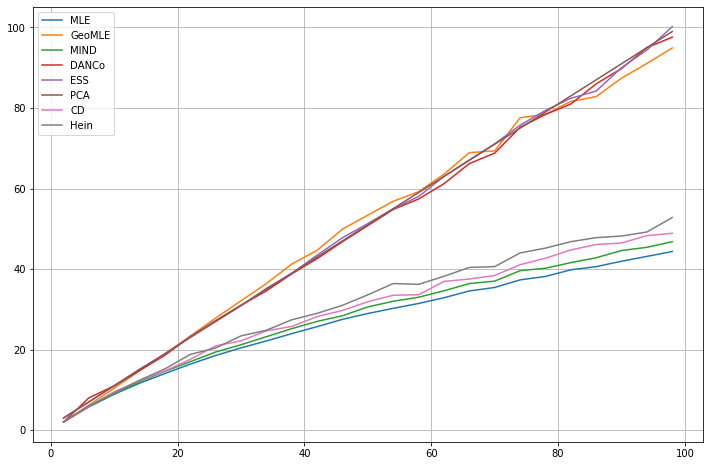

In [19]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for name in names:
    ax.plot(df_mean['RealDim'], df_mean[name], label=name)
    
ax.legend()
ax.grid()
plt.show()

In [20]:
df.to_csv('result/result_sphere.csv', index_label=False)

## Dolan More Curve

In [17]:
DE = DimEst()
DG = DataGenerator()

In [18]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid'])

In [19]:
steps = [
    ('Sphere',  5,  3),
    ('Sphere',  10, 5),
    ('Sphere',  15, 10),
    ('Sphere',  35, 30),
    ('Sphere',  55, 50),
    ('Sphere',  75, 70),
    
    ('Affine_3to5',  5,  3),
    ('Affine',       5,  5),
    ('Affine',       10, 10),
    ('Affine',       20, 20),
    
    ('Nonlinear_4to6',  6,  4),
    ('Nonlinear',       8,  4),
    ('Nonlinear',       36, 6),
    ('Nonlinear',       64, 8),
    ('Nonlinear',       72, 12),
    
    ('Spiral',   3,  1),
    ('Spiral',   13, 1),
    ('Helix1d',  3,  1),
    ('Helix1d',  13, 1),
    ('Helix2d',  3,  2),
    ('Helix2d',  13, 2),
    ('Helicoid', 3,  2),
    ('Helicoid', 13, 2),
    ('Roll',     3,  2),
    ('Roll',     13, 2),
    ('Scurve',   3,  2),
    ('Scurve',   13, 2),
    ('Moebius',  3,  2),
    
    ('Uniform', 10, 5),
    ('Uniform', 15, 10),
    ('Uniform', 35, 30),
    ('Uniform', 55, 50),
    ('Uniform', 75, 70),
     
    ('Norm', 20, 20),
    ('Norm', 50, 20),
    ('Norm', 50, 50),
    ('Norm', 70, 50),
    
    ('Paraboloid', 12, 3),
    ('Paraboloid', 21, 6),
    ('Paraboloid', 30, 9),
    ('Paraboloid', 39, 12),
    ('Paraboloid', 48, 15),
    
    ('Cubic', 5,  3),
    ('Cubic', 35, 30),
    ('Cubic', 90, 70),
]

In [20]:
def add_args(const_args, step):
    args = {**const_args}
    args['name'] = step[0]
    args['D'] = step[1]
    args['d'] = step[2]
    assert len({'name', 'D', 'd', 'N', 'noise'} & set(args.keys())) == 5
    return args

In [21]:
n_repetition = 10
args = {'N': 1000, 'noise': 0}
df, df_time = run_test(run_one_test, steps, args, n_repetition)

100%|██████████| 450/450 [09:16<00:00,  1.07s/it]


In [22]:
df.to_csv('result/result_dm.csv', index_label=False)

In [23]:
df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).std()

MLE    GeoMLE      MIND     DANCo  \
Dataset        Num    Dim  RealDim                                           
Affine         1000.0 5.0  5.0      0.035065  0.000000  0.000000  0.000000   
                      10.0 10.0     0.081502  0.000000  0.000000  0.000000   
                      20.0 20.0     0.098593  0.000000  0.483046  0.316228   
Affine_3to5    1000.0 5.0  3.0      0.033545  0.087676  0.000000  0.000000   
Cubic          1000.0 5.0  3.0      0.031244  0.074853  0.000000  0.421637   
                      35.0 30.0     0.213509  0.791642  0.483046  1.247219   
                      90.0 70.0     0.451400  2.293846  0.471405  2.496664   
Helicoid       1000.0 3.0  2.0      0.019705  0.041651  0.000000  0.000000   
                      13.0 2.0      0.019972  0.042035  0.000000  0.000000   
Helix1d        1000.0 3.0  1.0      0.009218  0.059093  0.000000  0.000000   
                      13.0 1.0      0.009271  0.073028  0.000000  0.000000   
Helix2d        1000.0 3.0  2.0      0.028115  0.059591  0.316228  0.000000   
                      13.0 2.0      0.027454  0.207998  0.421637  0.000000   
Moebius        1000.0 3.0  2.0      0.023122  0.037098  0.000000  0.000000   
Nonlinear      1000.0 8.0  4.0      0.038787  0.098775  0.000000  0.000000   
                      36.0 6.0      0.078235  0.183723  0.000000  0.000000   
                      64.0 8.0      0.097570  0.242878  0.421637  0.000000   
                      72.0 12.0     0.082198  0.396951  0.516398  0.674949   
Nonlinear_4to6 1000.0 6.0  4.0      0.030045  0.105730  0.000000  0.000000   
Norm           1000.0 20.0 20.0     0.122795  0.076918  0.483046  0.421637   
                      50.0 20.0     0.079818  0.724366  0.316228  1.154701   
                           50.0     0.234479  0.040794  0.516398  1.398412   
                      70.0 50.0     0.283665  1.115797  0.788811  3.604010   
Paraboloid     1000.0 12.0 3.0      0.024569  0.059725  0.000000  0.000000   
                      21.0 6.0      0.061280  0.122830  0.000000  0.516398   
                      30.0 9.0      0.050803  0.230199  0.000000  0.000000   
                      39.0 12.0     0.065798  0.481997  0.000000  0.421637   
                      48.0 15.0     0.092229  0.442073  0.527046  0.316228   
Roll           1000.0 3.0  2.0      0.029030  0.213253  0.000000  0.000000   
                      13.0 2.0      0.019478  0.207443  0.000000  0.000000   
Scurve         1000.0 3.0  2.0      0.020383  0.036512  0.000000  0.000000   
                      13.0 2.0      0.013991  0.021931  0.000000  0.000000   
Sphere         1000.0 5.0  3.0      0.022358  0.039667  0.000000  0.000000   
                      10.0 5.0      0.053512  0.099825  0.000000  0.000000   
                      15.0 10.0     0.109343  0.310551  0.316228  0.483046   
                      35.0 30.0     0.152819  1.366688  0.421637  0.737865   
                      55.0 50.0     0.510717  2.811130  0.483046  0.966092   
                      75.0 70.0     0.218355  1.998434  0.788811  1.100505   
Spiral         1000.0 3.0  1.0      0.022906  0.117277  0.000000  0.000000   
                      13.0 1.0      0.017638  0.092227  0.000000  0.000000   
Uniform        1000.0 10.0 5.0      0.037354  0.120983  0.483046  0.000000   
                      15.0 10.0     0.118806  0.288002  0.316228  0.316228   
                      35.0 30.0     0.264395  1.204566  0.421637  0.966092   
                      55.0 50.0     0.260102  1.595731  0.483046  1.779513   
                      75.0 70.0     0.287508  1.797478  0.527046  1.316561   

                                         ESS  PCA        CD      Hein  
Dataset        Num    Dim  RealDim                                     
Affine         1000.0 5.0  5.0      0.069232  0.0  0.104206  0.000000  
                      10.0 10.0     0.186748  0.0  0.193694  0.316228  
                      20.0 20.0     0.324631  0.0  0.307209  0.632456  
Affine_3to5   

In [24]:
df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean()

MLE     GeoMLE  MIND  DANCo  \
Dataset        Num    Dim  RealDim                                      
Affine         1000.0 5.0  5.0       4.930458   5.000000   5.0    5.0   
                      10.0 10.0      8.966018  10.000000   9.0   10.0   
                      20.0 20.0     14.970399  20.000000  15.7   19.9   
Affine_3to5    1000.0 5.0  3.0       3.015755   3.100629   3.0    3.0   
Cubic          1000.0 5.0  3.0       3.074464   3.152485   3.0    3.8   
                      35.0 30.0     19.833355  31.363065  20.7   32.0   
                      90.0 70.0     33.961361  76.116119  36.0   76.3   
Helicoid       1000.0 3.0  2.0       2.100763   2.056065   2.0    2.0   
                      13.0 2.0       2.101091   2.074593   2.0    2.0   
Helix1d        1000.0 3.0  1.0       1.028923   1.078027   1.0    1.0   
                      13.0 1.0       1.026424   1.091295   1.0    1.0   
Helix2d        1000.0 3.0  2.0       2.865511   2.961160   2.9    3.0   
                      13.0 2.0       2.853198   3.450108   2.8    3.0   
Moebius        1000.0 3.0  2.0       2.096612   1.970469   2.0    2.0   
Nonlinear      1000.0 8.0  4.0       4.167713   3.849107   4.0    5.0   
                      36.0 6.0       6.330484   6.387864   6.0    8.0   
                      64.0 8.0       8.478081   9.235503   8.2   10.0   
                      72.0 12.0     12.473523  15.193799  12.4   15.7   
Nonlinear_4to6 1000.0 6.0  4.0       3.990448   4.095913   4.0    5.0   
Norm           1000.0 20.0 20.0     15.006693  19.975676  15.7   19.8   
                      50.0 20.0     14.997224  22.006241  15.9   21.0   
                           50.0     27.024201  49.987100  28.6   48.8   
                      70.0 50.0     27.187832  53.350951  28.8   50.1   
Paraboloid     1000.0 12.0 3.0       2.821944   2.932875   3.0    3.0   
                      21.0 6.0       4.719638   5.741539   5.0    6.6   
                      30.0 9.0       5.869474   8.624563   6.0    8.0   
                      39.0 12.0      6.620608  11.921570   7.0    8.2   
                      48.0 15.0      6.986238  13.862719   7.5    8.9   
Roll           1000.0 3.0  2.0       2.052537   2.068442   2.0    2.0   
                      13.0 2.0       2.045202   2.016323   2.0    2.0   
Scurve         1000.0 3.0  2.0       2.013696   2.004486   2.0    2.0   
                      13.0 2.0       2.019371   2.036236   2.0    2.0   
Sphere         1000.0 5.0  3.0       2.972549   3.019433   3.0    3.0   
                      10.0 5.0       4.620806   4.740066   5.0    6.0   
                      15.0 10.0      8.165100   8.587280   8.1   10.3   
                      35.0 30.0     19.712644  28.875181  20.2   29.1   
                      55.0 50.0     28.260819  48.698216  29.7   49.6   
                      75.0 70.0     35.350323  67.965429  37.2   68.9   
Spiral         1000.0 3.0  1.0       1.743925   2.096519   1.0    1.0   
                      13.0 1.0       1.749772   1.874628   1.0    1.0   
Uniform        1000.0 10.0 5.0       4.461036   4.642068   4.7    5.0   
                      15.0 10.0      8.062754   8.792460   8.1    9.9   
                      35.0 30.0     19.128647  29.075923  19.8   29.6   
                      55.0 50.0     27.242949  49.831984  28.7   50.5   
                      75.0 70.0     33.772089  71.188044  35.5   69.8   

                                          ESS   PCA         CD  Hein  
Dataset        Num    Dim  RealDim                                    
Affine         1000.0 5.0  5.0       4.998291   5.0   4.799093   5.0  
                      10.0 10.0     10.160410  10.0   8.443568   8.9  
                      20.0 20.0     20.040781  20.0  14.065409  14.8  
Affine_3to5    1000.0 5.0  3.0       2.651078   3.0   2.961429   3.0  
Cubic          1000.0 5.0  3.0       3.998133   4.0   2.987581   3.0  
                      35.0 30.0     31.059520  31.0  19.686443  20.5  
                      90.0 70.0     70.356

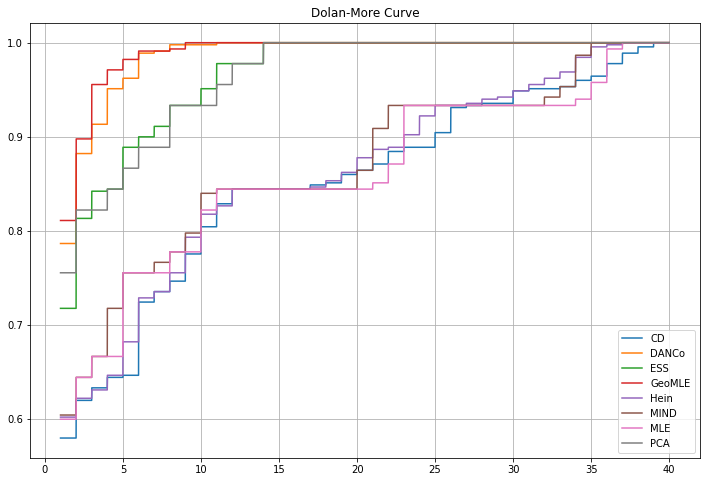

In [25]:
dfr = df.copy().round()
names = dfr.columns.difference(['Dataset', 'Num', 'Dim', 'RealDim'])

f, ax = plt.subplots(1, 1, figsize=(12, 8))
nsteps = 5001
max_tau = 40
errors_total = abs(dfr[names].sub(dfr['RealDim'], axis=0).values)
errors_total = np.max([errors_total, np.ones_like(errors_total)], axis=0)


taus = np.linspace(1, max_tau, nsteps)        
rhos = np.zeros((nsteps, len(names)))
for cnt, tau in enumerate(taus):
    rhos[cnt] = np.sum(errors_total <= tau, axis=0)

for i in range(len(names)):
    ax.plot(taus, rhos[:,i]/errors_total.shape[0], label=names[i])

ax.set_title('Dolan-More Curve')
ax.legend()
ax.grid()



In [26]:
pd.DataFrame(df_time[names].mean(axis=0)).T

,CD,DANCo,ESS,GeoMLE,Hein,MIND,MLE,PCA
0,0.080312,11.219618,0.273473,3.607782,0.079376,0.0498,0.354609,0.005669


In [27]:
pd.DataFrame(df_time[names].median(axis=0)).T

,CD,DANCo,ESS,GeoMLE,Hein,MIND,MLE,PCA
0,0.054208,5.00768,0.272108,3.355619,0.05409,0.015434,0.337945,0.001232


### Nonunform samplings

In [17]:
DE = DimEst()
DG = DataGenerator()

In [18]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid'])

In [19]:
steps = [
    ('Sphere',  5,  3),
    ('Sphere',  10, 5),
    ('Sphere',  15, 10),
    ('Sphere',  35, 30),
    ('Sphere',  55, 50),
    ('Sphere',  75, 70),
    
    ('Affine_3to5',  5,  3),
    ('Affine',       5,  5),
    ('Affine',       10, 10),
    ('Affine',       20, 20),
    
    ('Nonlinear_4to6',  6,  4),
    ('Nonlinear',       8,  4),
    ('Nonlinear',       36, 6),
    ('Nonlinear',       64, 8),
    ('Nonlinear',       72, 12),
    
    ('Spiral',   3,  1),
    ('Spiral',   13, 1),
    ('Helix1d',  3,  1),
    ('Helix1d',  13, 1),
    ('Helix2d',  3,  2),
    ('Helix2d',  13, 2),
    ('Helicoid', 3,  2),
    ('Helicoid', 13, 2),
    ('Roll',     3,  2),
    ('Roll',     13, 2),
    ('Scurve',   3,  2),
    ('Scurve',   13, 2),
    ('Moebius',  3,  2),
    
#     ('Uniform', 10, 5),
#     ('Uniform', 15, 10),
#     ('Uniform', 35, 30),
#     ('Uniform', 55, 50),
#     ('Uniform', 75, 70),
     
#     ('Norm', 20, 20),
#     ('Norm', 50, 20),
#     ('Norm', 50, 50),
#     ('Norm', 70, 50),
    
    ('Paraboloid', 12, 3),
    ('Paraboloid', 21, 6),
    ('Paraboloid', 30, 9),
    ('Paraboloid', 39, 12),
    ('Paraboloid', 48, 15),
    
    ('Cubic', 5,  3),
    ('Cubic', 35, 30),
    ('Cubic', 90, 70),
]

In [20]:
def add_args(const_args, step):
    args = {**const_args}
    args['name'] = step[0]
    args['D'] = step[1]
    args['d'] = step[2]
    assert len({'name', 'D', 'd', 'N', 'noise'} & set(args.keys())) == 5
    return args

In [21]:
n_repetition = 10
args = {'N': 1000, 'noise': 0, 'sampler': 'nonuniform'}
df, df_time = run_test(run_one_test, steps, args, n_repetition)

100%|██████████| 360/360 [06:25<00:00,  1.11it/s]


In [37]:
df.to_csv('result/result_dm_nonuniform.csv', index_label=False)

In [23]:
df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).std()

MLE    GeoMLE      MIND     DANCo  \
Dataset        Num    Dim  RealDim                                           
Affine         1000.0 5.0  5.0      0.057011  0.000000  0.000000  0.000000   
                      10.0 10.0     0.054502  0.000000  0.000000  0.000000   
                      20.0 20.0     0.153966  0.000000  0.483046  0.516398   
Affine_3to5    1000.0 5.0  3.0      0.032427  0.056392  0.000000  0.316228   
Cubic          1000.0 5.0  3.0      0.036834  0.060966  0.000000  0.483046   
                      35.0 30.0     0.217212  1.210512  0.471405  1.178511   
                      90.0 70.0     0.226077  1.541667  0.421637  2.514403   
Helicoid       1000.0 3.0  2.0      0.025766  0.043107  0.000000  0.000000   
                      13.0 2.0      0.019760  0.043588  0.000000  0.000000   
Helix1d        1000.0 3.0  1.0      0.013099  0.047659  0.000000  0.000000   
                      13.0 1.0      0.012021  0.076792  0.000000  0.000000   
Helix2d        1000.0 3.0  2.0      0.037957  0.090136  0.421637  0.000000   
                      13.0 2.0      0.026531  0.276708  0.483046  0.000000   
Moebius        1000.0 3.0  2.0      0.020910  0.040348  0.000000  0.000000   
Nonlinear      1000.0 8.0  4.0      0.040677  0.121451  0.000000  0.316228   
                      36.0 6.0      0.061174  0.249713  0.000000  0.316228   
                      64.0 8.0      0.087959  0.147326  0.483046  0.316228   
                      72.0 12.0     0.132822  0.316733  0.483046  1.229273   
Nonlinear_4to6 1000.0 6.0  4.0      0.048322  0.114205  0.000000  0.421637   
Paraboloid     1000.0 12.0 3.0      0.024473  0.063066  0.000000  0.316228   
                      21.0 6.0      0.031023  0.050558  0.000000  0.483046   
                      30.0 9.0      0.059484  0.291227  0.000000  0.421637   
                      39.0 12.0     0.091486  0.301126  0.000000  0.483046   
                      48.0 15.0     0.104522  0.369739  0.421637  0.000000   
Roll           1000.0 3.0  2.0      0.023143  0.274954  0.000000  0.000000   
                      13.0 2.0      0.023148  0.235621  0.000000  0.000000   
Scurve         1000.0 3.0  2.0      0.023960  0.040683  0.000000  0.000000   
                      13.0 2.0      0.020006  0.036721  0.000000  0.000000   
Sphere         1000.0 5.0  3.0      0.039735  0.059998  0.000000  0.000000   
                      10.0 5.0      0.054152  0.128141  0.000000  0.567646   
                      15.0 10.0     0.081613  0.358920  0.421637  0.483046   
                      35.0 30.0     0.162017  1.257985  0.316228  0.316228   
                      55.0 50.0     0.171143  1.654837  0.516398  0.567646   
                      75.0 70.0     0.481577  2.374995  0.316228  0.966092   
Spiral         1000.0 3.0  1.0      0.020191  0.140179  0.000000  0.316228   
                      13.0 1.0      0.028622  0.113780  0.000000  0.000000   

                                         ESS  PCA        CD      Hein  
Dataset        Num    Dim  RealDim                                     
Affine         1000.0 5.0  5.0      0.081196  0.0  0.052537  0.000000  
                      10.0 10.0     0.221477  0.0  0.240310  0.000000  
                      20.0 20.0     0.357111  0.0  0.238909  0.516398  
Affine_3to5    1000.0 5.0  3.0      0.060059  0.0  0.094961  0.000000  
Cubic          1000.0 5.0  3.0      0.056874  0.0  0.100890  0.000000  
                      35.0 30.0     0.733148  0.0  0.659746  0.632456  
                      90.0 70.0     1.808571  0.0  0.599448  1.159502  
Helicoid       1000.0 3.0  2.0      0.050754  0.0  0.062193  0.000000  
                      13.0 2.0      0.041355  0.0  0.075762  0.000000  
Helix1d        1000.0 3.0  1.0      0.042133  0.0  0.032860  0.000000  
                      13.0 1.0      0.016075  0.0  0.030370  0.000000  
Helix2d        1000.0 3.0  2.0      0.025379  0.0  0.067960  0.000000  
                      13.0 2.0      0.024355  0.0  0.062197  0.00000

In [24]:
df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean()

MLE     GeoMLE  MIND  DANCo  \
Dataset        Num    Dim  RealDim                                      
Affine         1000.0 5.0  5.0       4.947358   5.000000   5.0    5.0   
                      10.0 10.0      8.966262  10.000000   9.0   10.0   
                      20.0 20.0     14.894529  20.000000  15.3   19.6   
Affine_3to5    1000.0 5.0  3.0       3.031419   3.160838   3.0    3.1   
Cubic          1000.0 5.0  3.0       3.043225   3.111464   3.0    3.7   
                      35.0 30.0     20.086530  31.937911  21.0   32.5   
                      90.0 70.0     34.001406  74.455212  36.2   73.9   
Helicoid       1000.0 3.0  2.0       2.104682   2.032672   2.0    2.0   
                      13.0 2.0       2.094964   2.038331   2.0    2.0   
Helix1d        1000.0 3.0  1.0       1.027447   1.116672   1.0    1.0   
                      13.0 1.0       1.024268   1.105118   1.0    1.0   
Helix2d        1000.0 3.0  2.0       2.867006   2.971497   2.8    3.0   
                      13.0 2.0       2.845772   3.493639   2.3    3.0   
Moebius        1000.0 3.0  2.0       2.086069   1.958994   2.0    2.0   
Nonlinear      1000.0 8.0  4.0       4.148890   3.847104   4.0    5.1   
                      36.0 6.0       6.344383   6.395282   6.0    7.9   
                      64.0 8.0       8.442001   9.152830   8.3    9.9   
                      72.0 12.0     12.357553  15.059066  12.3   15.8   
Nonlinear_4to6 1000.0 6.0  4.0       4.011074   4.132309   4.0    5.2   
Paraboloid     1000.0 12.0 3.0       2.824547   2.959841   3.0    3.1   
                      21.0 6.0       4.734059   5.720196   5.0    6.7   
                      30.0 9.0       5.898408   8.626479   6.0    7.8   
                      39.0 12.0      6.632612  11.778924   7.0    8.3   
                      48.0 15.0      6.928652  13.990164   7.2    9.0   
Roll           1000.0 3.0  2.0       2.044907   2.188496   2.0    2.0   
                      13.0 2.0       2.042777   2.048390   2.0    2.0   
Scurve         1000.0 3.0  2.0       2.023922   2.012339   2.0    2.0   
                      13.0 2.0       2.021971   2.043400   2.0    2.0   
Sphere         1000.0 5.0  3.0       2.991674   3.048682   3.0    3.0   
                      10.0 5.0       4.644162   4.764193   5.0    6.1   
                      15.0 10.0      8.249199   8.737347   8.2   10.3   
                      35.0 30.0     19.543761  28.663304  20.1   29.1   
                      55.0 50.0     28.325375  48.851979  29.4   49.1   
                      75.0 70.0     35.241429  69.399440  37.1   69.6   
Spiral         1000.0 3.0  1.0       1.768194   2.113273   1.0    1.1   
                      13.0 1.0       1.757032   1.888346   1.0    1.0   

                                          ESS   PCA         CD  Hein  
Dataset        Num    Dim  RealDim                                    
Affine         1000.0 5.0  5.0       5.030711   5.0   4.729769   5.0  
                      10.0 10.0     10.020266  10.0   8.407129   9.0  
                      20.0 20.0     20.038807  20.0  13.766084  14.6  
Affine_3to5    1000.0 5.0  3.0       2.591780   3.0   2.950700   3.0  
Cubic          1000.0 5.0  3.0       3.989455   4.0   2.876301   3.0  
                      35.0 30.0     31.145365  31.0  19.918391  20.8  
                      90.0 70.0     70.467573  71.0  32.180029  34.7  
Helicoid       1000.0 3.0  2.0       2.243067   3.0   2.066231   2.0  
                      13.0 2.0       2.228801   3.0   1.987411   2.0  
Helix1d        1000.0 3.0  1.0       2.690538   3.0   0.999082   1.0  
                      13.0 1.0       2.686177   3.0   0.985602   1.0  
Helix2d        1000.0 3.0  2.0       2.334729   3.0   1.978099   2.0  
                      13.0 2.0       2.325881   3.0   1.965401   2.0  
Moebius        1000.0 3.0  2.0       2.112699   2.0   1.989509   2.0  
Nonlinear      1000.0 8.0  4.0       7.236425   8.0   3.907684   4.0  
                      36.0 6.0      10.943570  12.0   5.8201

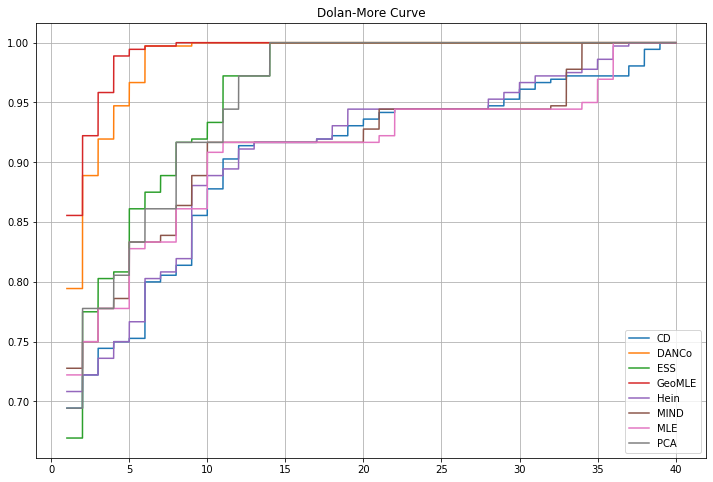

In [25]:
dfr = df.copy().round()
names = dfr.columns.difference(['Dataset', 'Num', 'Dim', 'RealDim'])

f, ax = plt.subplots(1, 1, figsize=(12, 8))
nsteps = 5001
max_tau = 40
errors_total = abs(dfr[names].sub(dfr['RealDim'], axis=0).values)
errors_total = np.max([errors_total, np.ones_like(errors_total)], axis=0)


taus = np.linspace(1, max_tau, nsteps)        
rhos = np.zeros((nsteps, len(names)))
for cnt, tau in enumerate(taus):
    rhos[cnt] = np.sum(errors_total <= tau, axis=0)

for i in range(len(names)):
    ax.plot(taus, rhos[:,i]/errors_total.shape[0], label=names[i])

ax.set_title('Dolan-More Curve')
ax.legend()
ax.grid()



## Dependece on noise

In [44]:
DE = DimEst()
DG = DataGenerator()

In [45]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid'])

In [46]:
steps = [
    ('Sphere',  5,  3),
    ('Sphere',  10, 5),
    ('Sphere',  15, 10),
    ('Sphere',  35, 30),
    ('Sphere',  55, 50),
    ('Sphere',  75, 70),
    
    ('Affine_3to5',  5,  3),
    ('Affine',       5,  5),
    ('Affine',       10, 10),
    ('Affine',       20, 20),
    
    ('Nonlinear_4to6',  6,  4),
    ('Nonlinear',       8,  4),
    ('Nonlinear',       36, 6),
    ('Nonlinear',       64, 8),
    ('Nonlinear',       72, 12),
    
    ('Spiral',   3,  1),
    ('Spiral',   13, 1),
    ('Helix1d',  3,  1),
    ('Helix1d',  13, 1),
    ('Helix2d',  3,  2),
    ('Helix2d',  13, 2),
    ('Helicoid', 3,  2),
    ('Helicoid', 13, 2),
    ('Roll',     3,  2),
    ('Roll',     13, 2),
    ('Scurve',   3,  2),
    ('Scurve',   13, 2),
    ('Moebius',  3,  2),
    
    ('Uniform', 10, 5),
    ('Uniform', 15, 10),
    ('Uniform', 35, 30),
    ('Uniform', 55, 50),
    ('Uniform', 75, 70),
     
    ('Norm', 20, 20),
    ('Norm', 50, 20),
    ('Norm', 50, 50),
    ('Norm', 70, 50),
    
    ('Paraboloid', 12, 3),
    ('Paraboloid', 21, 6),
    ('Paraboloid', 30, 9),
    ('Paraboloid', 39, 12),
    ('Paraboloid', 48, 15),
    
    ('Cubic', 5,  3),
    ('Cubic', 35, 30),
    ('Cubic', 90, 70),
]

In [47]:
len(steps)

45

In [48]:
def add_args(const_args, step):
    args = {}
    args['N'] = const_args['N']
    args['noise'] = const_args['noise']
    args['name'] = step[0]
    args['D'] = step[1]
    args['d'] = step[2]
    return args

In [49]:
noise_steps = [0, 0.01, 0.02, 0.03, 0.04, 0.05]                     

In [50]:
names = DE.names
n_repetition = 5

mpe = []
std = []
for noise in noise_steps:
    args = {'N': 1000, 'noise': noise}
    df = run_test(run_one_test, steps, args, n_repetition, 12)
    dfr = df.round()
    mpe_i = abs(dfr[names].sub(dfr['RealDim'], axis=0)).mul(dfr['RealDim']**-1, axis=0).values
    mpe.append(mpe_i.mean(axis=0))
    std.append(mpe_i.std(axis=0)/np.sqrt(mpe_i.shape[0]))

mpe = np.array(mpe)
std = np.array(std)

100%|██████████| 225/225 [04:18<00:00,  1.09s/it]


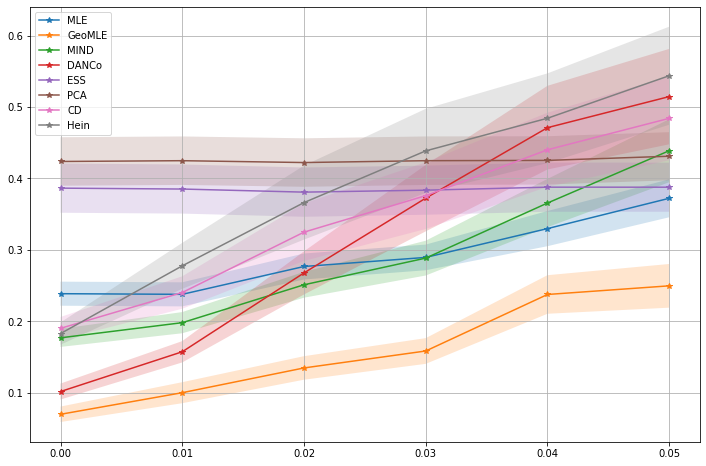

In [62]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for mpe_i, std_i, name in zip(mpe.T, std.T, names):
    ax.plot(noise_steps, mpe_i, '-*', label=name)
    ax.fill_between(noise_steps, mpe_i - std_i, mpe_i + std_i, alpha=0.2)
    
ax.legend()
ax.grid()
plt.show()

In [65]:
result = pd.DataFrame(mpe, columns=names)
result['noise'] = noise_steps
result.to_csv('result/result_noise_mpe.csv', index_label=False)

In [66]:
result = pd.DataFrame(std, columns=names)
result['noise'] = noise_steps
result.to_csv('result/result_noise_std.csv', index_label=False)

## Time dependance

### Dim

In [109]:
DE = DimEst()
DG = DataGenerator()
DG.dict_gen.keys()

steps = np.arange(5, 101, 5).tolist()
args = {'name': 'Sphere',
        'N': 1000,
        'noise': 0}

In [110]:
def add_args(const_args, step):
    args = {**const_args}
    args['d'] = step
    args['D'] = step + 1
    assert len({'name', 'D', 'd', 'N', 'noise'} & set(args.keys())) == 5
    return args

In [111]:
names = DE.names
n_repetition = 5

df = run_test(run_one_test, steps, args, n_repetition, return_time=True)

100%|██████████| 100/100 [03:14<00:00,  2.68s/it]


In [114]:
df_mean = df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean().reset_index()

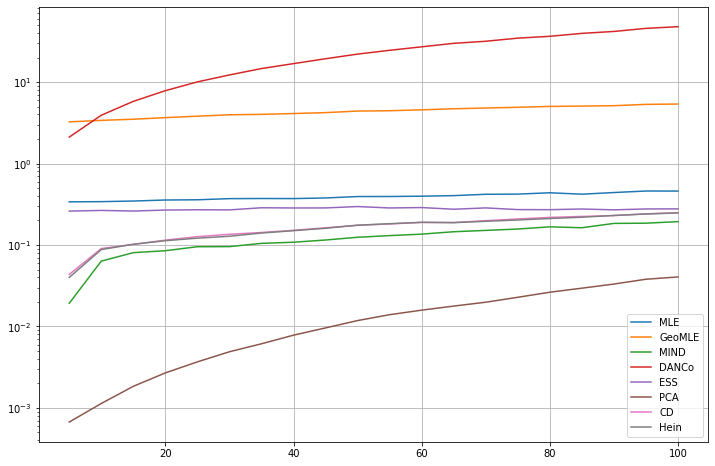

In [117]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for name in names:
    ax.plot(df_mean['RealDim'], df_mean[name], label=name)
    
plt.yscale('log')
ax.legend()
ax.grid()
plt.show()

In [118]:
df.to_csv('result/result_time_dim.csv', index_label=False)

### Num

In [29]:
DE = DimEst()
DG = DataGenerator()
DG.dict_gen.keys()

steps = np.concatenate((np.arange(100, 1000, 200), 
                          np.arange(1000, 2000, 250), 
                          np.arange(2000, 10001, 500))).tolist()  
args = {'name': 'Sphere',
        'D': 11,
        'd': 10,
        'noise': 0}

In [30]:
def add_args(const_args, step):
    args = {**const_args}
    args['N'] = step
    assert len({'name', 'D', 'd', 'N', 'noise'} & set(args.keys())) == 5
    return args

In [31]:
names = DE.names
n_repetition = 5

df = run_test(run_one_test, steps, args, n_repetition, return_time=True)

 95%|█████████▌| 124/130 [06:18<00:14,  2.48s/it]

WRONG with {'name': 'Sphere', 'D': 11, 'd': 10, 'noise': 0, 'N': 8000}


100%|██████████| 130/130 [06:33<00:00,  2.89s/it]


In [32]:
df_mean = df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean().reset_index()

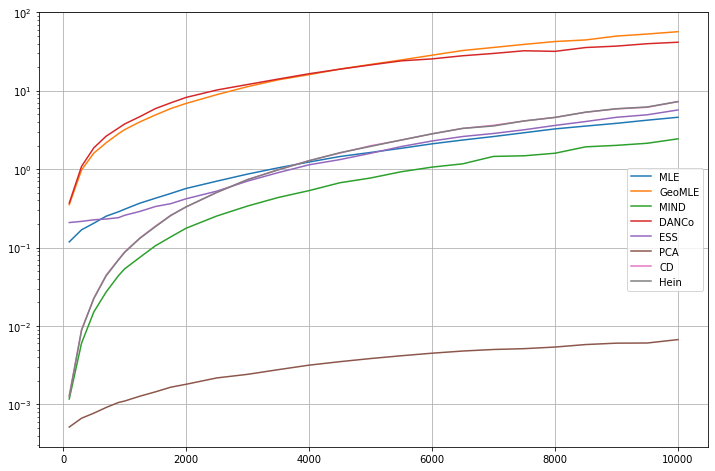

In [33]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for name in names:
    ax.plot(df_mean['Num'], df_mean[name], label=name)
    
plt.yscale('log')
ax.legend()
ax.grid()
plt.show()

In [34]:
df.to_csv('result/result_time_num.csv', index_label=False)

## EXTRA EXPERIMENTS

## Dependacne of Num points

In [15]:
DE = DimEst()
DG = DataGenerator()

In [16]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid'])

In [20]:
steps = [
    ('Sphere',  5,  3),
    ('Sphere',  10, 5),
    ('Sphere',  15, 10),
    ('Sphere',  35, 30),
    ('Sphere',  55, 50),
    ('Sphere',  75, 70),
    ('Sphere',  100, 75),
    ('Sphere',  125, 100),
    
    ('Affine_3to5',  5,  3),
    ('Affine',       5,  5),
    ('Affine',       10, 10),
    ('Affine',       20, 20),
    
    ('Nonlinear_4to6',  6,  4),
    ('Nonlinear',       8,  4),
    ('Nonlinear',       36, 6),
    ('Nonlinear',       64, 8),
    ('Nonlinear',       72, 12),
    
    ('Spiral',   3,  1),
    ('Spiral',   13, 1),
    ('Helix1d',  3,  1),
    ('Helix1d',  13, 1),
    ('Helix2d',  3,  2),
    ('Helix2d',  13, 2),
    ('Helicoid', 3,  2),
    ('Helicoid', 13, 2),
    ('Roll',     3,  2),
    ('Roll',     13, 2),
    ('Scurve',   3,  2),
    ('Scurve',   13, 2),
    ('Moebius',  3,  2),
    
    ('Uniform', 10, 5),
    ('Uniform', 15, 10),
    ('Uniform', 35, 30),
    ('Uniform', 55, 50),
    ('Uniform', 75, 70),
     
    ('Norm', 20, 20),
    ('Norm', 50, 20),
    ('Norm', 50, 50),
    ('Norm', 70, 50),
    
    ('Paraboloid', 12, 3),
    ('Paraboloid', 21, 6),
    ('Paraboloid', 30, 9),
    ('Paraboloid', 39, 12),
    ('Paraboloid', 48, 15),
    
    ('Cubic', 5,  3),
    ('Cubic', 35, 30),
    ('Cubic', 90, 70),
]

In [21]:
len(steps)

47

In [22]:
N_steps = np.concatenate((np.arange(100, 1000, 200), 
                          np.arange(1000, 2000, 250), 
                          np.arange(2000, 3501, 500)))                      

In [23]:
N_steps

array([ 100,  300,  500,  700,  900, 1000, 1250, 1500, 1750, 2000, 2500,
       3000, 3500])

In [24]:
all_steps = [(N, name, D, d) for name, D, d in steps for N in N_steps]

In [25]:
len(all_steps)

611

In [26]:
def add_args(const_args, step):
    args = {}
    args['noise'] = const_args['noise']
    args['N'] = step[0]
    args['name'] = step[1]
    args['D'] = step[2]
    args['d'] = step[3]
    return args

In [27]:
names = DE.names
n_repetition = 5

mpe = []
args = {'noise': 0}
df = run_test(run_one_test, all_steps, args, n_repetition)

  3%|▎         | 77/3055 [01:18<2:24:44,  2.92s/it]

WRONG with {'noise': 0, 'N': 100, 'name': 'Sphere', 'D': 75, 'd': 70}


  3%|▎         | 103/3055 [03:54<6:06:36,  7.45s/it]

WRONG with {'noise': 0, 'N': 100, 'name': 'Sphere', 'D': 125, 'd': 100}


 23%|██▎       | 701/3055 [36:00<6:05:57,  9.33s/it] 

WRONG with {'noise': 0, 'N': 100, 'name': 'Sphere', 'D': 100, 'd': 75}


 23%|██▎       | 714/3055 [38:13<10:14:04, 15.74s/it]

WRONG with {'noise': 0, 'N': 100, 'name': 'Sphere', 'D': 125, 'd': 100}


 29%|██▉       | 882/3055 [50:20<1:16:04,  2.10s/it] 

[1]
 1


[1]
 1


WRONG with {'noise': 0, 'N': 2000, 'name': 'Helix1d', 'D': 3, 'd': 1}


 35%|███▍      | 1065/3055 [54:56<2:07:23,  3.84s/it]

WRONG with {'noise': 0, 'N': 100, 'name': 'Uniform', 'D': 75, 'd': 70}


 43%|████▎     | 1312/3055 [1:11:34<5:40:16, 11.71s/it]

WRONG with {'noise': 0, 'N': 100, 'name': 'Sphere', 'D': 100, 'd': 75}


 43%|████▎     | 1325/3055 [1:13:48<8:12:40, 17.09s/it]

WRONG with {'noise': 0, 'N': 100, 'name': 'Sphere', 'D': 125, 'd': 100}


 60%|█████▉    | 1832/3055 [1:41:11<1:31:04,  4.47s/it]

WRONG with {'noise': 0, 'N': 100, 'name': 'Cubic', 'D': 90, 'd': 70}


 63%|██████▎   | 1936/3055 [1:49:35<4:43:01, 15.18s/it]

WRONG with {'noise': 0, 'N': 100, 'name': 'Sphere', 'D': 125, 'd': 100}


 83%|████████▎ | 2547/3055 [2:25:48<2:31:47, 17.93s/it]

WRONG with {'noise': 0, 'N': 100, 'name': 'Sphere', 'D': 125, 'd': 100}


100%|██████████| 3055/3055 [2:53:25<00:00,  4.63s/it]  


In [65]:
dfr = df.round()

In [68]:
names

['MLE', 'GeoMLE', 'MIND', 'DANCo', 'ESS', 'PCA', 'CD', 'Hein']

In [66]:
dfr[names] = abs(dfr[names].sub(dfr['RealDim'], axis=0)).mul(dfr['RealDim']**-1, axis=0)

mpe = dfr.groupby('Num')[names].mean().values
std = dfr.groupby('Num')[names].std().values / dfr.groupby('Num')[names].count().values

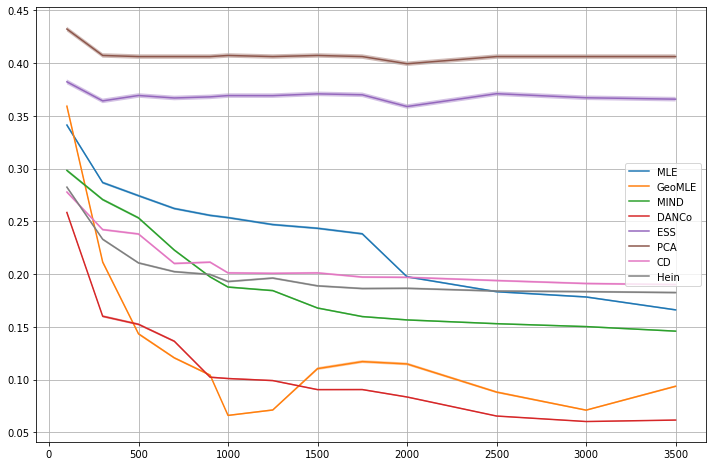

In [71]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for mpe_i, std_i, name in zip(mpe.T, std.T, names):
    ax.plot(N_steps, mpe_i, label=name)
    ax.fill_between(N_steps, mpe_i-std_i, mpe_i+std_i, alpha=0.4)
    
ax.legend(loc=5)
ax.grid()
plt.show()

In [63]:
df.to_csv('result/result_num.csv', index_label=False)